# LTSM


In [1]:
# Standard library imports
import os
import glob
import datetime
# Data handling
import pandas as pd
import numpy as np
# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# Machine Learning and Neural Network
from tensorflow.keras.utils import to_categorical
# Utilities
from tqdm import tqdm
# Visualization
import matplotlib.pyplot as plt
# Additional utilities
from collections import Counter


## Dataset

In [2]:
# Step 1: 列出所有文件
rf_files = glob.glob('RF1_csv/*_HF.csv')  # RF数据文件的路径和模式
label_dirs = glob.glob('CV_csv/')  # 标签数据文件夹的路径

# Step 2: 解析文件名以提取时间，并创建一个映射关系
rf_times_files = {datetime.datetime.strptime(os.path.basename(f).split('_')[0], "%y%m%d%H%M%S"): f for f in rf_files}

label_files = []
for d in label_dirs:
    label_files.extend(glob.glob(f'{d}*.csv'))

label_times_files = {
    datetime.datetime.strptime(
        os.path.basename(f).split('_')[1].split('.')[0],  # 修正点在这里
        "%Y-%m-%d %H-%M-%S"
    ): f for f in label_files
}

# Step 3: 匹配RF数据和标签文件
matched_files = []
for rf_time, rf_file in rf_times_files.items():
    # 找到最接近rf_time的标签文件时间
    closest_label_time = min(label_times_files.keys(), key=lambda x: abs(x - rf_time))
    if abs(closest_label_time - rf_time) < datetime.timedelta(minutes=1):  # 假设时间差小于1分钟则视为匹配
        matched_files.append((rf_file, label_times_files[closest_label_time]))

## Checking the dataset

In [3]:
print(f"找到并匹配的文件对数量: {len(matched_files)}")

找到并匹配的文件对数量: 43


In [4]:
for i, (rf_file, label_file) in enumerate(matched_files[:5]):  # 打印前5对文件路径作为示例
    print(f"Paring No. {i+1}:")
    print(f"    RF Data file: {rf_file}")
    print(f"    Label Data file: {label_file}")
    print("-" * 60)

Paring No. 1:
    RF Data file: RF1_csv/240229152800_30M__ch0Ref_Arr_HF.csv
    Label Data file: CV_csv/demo_2024-02-29 15-28-00.csv
------------------------------------------------------------
Paring No. 2:
    RF Data file: RF1_csv/240229152000_30M__ch0Ref_Arr_HF.csv
    Label Data file: CV_csv/demo_2024-02-29 15-20-00.csv
------------------------------------------------------------
Paring No. 3:
    RF Data file: RF1_csv/240228163700_30M__ch0Ref_Arr_HF.csv
    Label Data file: CV_csv/demo_2024-02-28 16-37-00.csv
------------------------------------------------------------
Paring No. 4:
    RF Data file: RF1_csv/240229152400_30M__ch0Ref_Arr_HF.csv
    Label Data file: CV_csv/demo_2024-02-29 15-24-00.csv
------------------------------------------------------------
Paring No. 5:
    RF Data file: RF1_csv/240229150800_30M__ch0Ref_Arr_HF.csv
    Label Data file: CV_csv/demo_2024-02-29 15-08-00.csv
------------------------------------------------------------


## Preprocessing

In [5]:
# 自定义处理标签数据的函数
def get_majority_action(group):
    if group.isnull().all().all() or (group.drop('time', axis=1) == 0).all().all():  # 检查组是否全部为NaN或0，忽略时间列
        return "label empty"  # 如果是，返回一个特殊标记
    else:
        # 计算每行的最大值索引
        max_idx = group.drop('time', axis=1).idxmax(axis=1)
        # 选择出现次数最多的动作作为这个时间段的代表动作
        max_action = max_idx.value_counts().idxmax()
        return max_action

# 初始化归一化器
scaler = MinMaxScaler()

# 用于存储处理后的RF数据和标签的列表
rf_data_processed = []
labels_processed = []

# 处理所有配对的文件
for rf_file, label_file in tqdm(matched_files):
    # 加载并预处理RF数据
    rf_data = pd.read_csv(rf_file, header=None, skiprows=849, nrows=301)
    rf_data_normalized = scaler.fit_transform(rf_data)
    rf_data_processed.append(rf_data_normalized)
    
    # 加载标签数据
    label_data = pd.read_csv(label_file)
    label_data['time'] = label_data['time'].apply(lambda x: int(x // 3))  # 重要：以xx行聚合
    
    # 对每个时间段应用自定义函数
    aggregated_records = []  # 初始化一个空列表来收集所有的记录
    for name, group in label_data.groupby('time'):
        action = get_majority_action(group)
        aggregated_records.append({'time': name, 'action': action})  # 将记录添加到列表
    
    aggregated_labels = pd.DataFrame(aggregated_records)  # 使用收集到的记录一次性创建DataFrame
    labels_processed.append(aggregated_labels)

# 此时，rf_data_processed 和 labels_processed 分别存储了所有RF数据和标签数据的处理结果

100%|██████████| 43/43 [00:08<00:00,  5.18it/s]


In [6]:
# 提取每个标签数据的第二列（动作列）
labels_processed = [df.iloc[:, 1] for df in labels_processed]  # 假设动作是第二列

# 打印第一个处理后的动作数据的前几个元素查看
print("第一个处理后的动作数据（前5个）:")
print(labels_processed[0].head())

第一个处理后的动作数据（前5个）:
0    walk
1    walk
2    walk
3    walk
4    walk
Name: action, dtype: object


In [7]:
# 检查第一个RF数据的维度
print("RF数据（处理后）的维度:")
print(np.array(rf_data_processed[0]).shape)

# 检查第一个标签数据的维度
print("\n标签数据（处理后）的维度:")
print(labels_processed[0].shape)

RF数据（处理后）的维度:
(301, 591)

标签数据（处理后）的维度:
(289,)


In [8]:
# 打印第一个处理后的RF数据的前几行
print("RF数据（处理后）的前几行:")
print(rf_data_processed[0][:5])
# 打印第一个处理后的标签数据
print("\n标签数据（处理后）的前几行:")
print(labels_processed[0].head(5))

RF数据（处理后）的前几行:
[[0.33511218 0.3246559  0.1769667  ... 0.4288579  0.46922752 0.37684023]
 [0.31410761 0.28567242 0.21595756 ... 0.43766657 0.48280574 0.42945585]
 [0.30663383 0.27125969 0.20764599 ... 0.39416705 0.4337259  0.39735328]
 [0.2926096  0.34056414 0.32399017 ... 0.14358194 0.32227921 0.31435071]
 [0.14773206 0.3256823  0.33236693 ... 0.31383693 0.27494506 0.12866809]]

标签数据（处理后）的前几行:
0    walk
1    walk
2    walk
3    walk
4    walk
Name: action, dtype: object


In [9]:
# 验证RF数据类型
print("RF数据类型:")
print(type(rf_data_processed[0]))

# 验证标签数据类型
print("\n标签数据类型:")
print(labels_processed[0].dtypes)


RF数据类型:
<class 'numpy.ndarray'>

标签数据类型:
object


In [10]:
# 统计第一个标签数据中各动作标签的数量
print("\n标签分布情况:")
print(labels_processed[0].value_counts())



标签分布情况:
action
walk            115
sit              74
stand            60
carry (an O)     17
bend              8
touch (an O)      8
get up            4
put down          3
Name: count, dtype: int64


In [11]:
# 新建一个列表来保存平均后的数据
rf_data_averaged = []

for data in rf_data_processed:
    # 检查列数，确保是偶数列，如果是奇数列，去掉最后一列
    if data.shape[1] % 2 != 0:
        data = data[:, :-1]

    # 将数据重塑，使得每两列成为一组
    # data.shape[0] 是行数，data.shape[1]//2 是将列数减半
    reshaped_data = data.reshape(data.shape[0], -1, 2)
    
    # 计算每两列的平均值
    averaged_data = reshaped_data.mean(axis=2)
    
    # 将平均后的数据添加到新列表中
    rf_data_averaged.append(averaged_data)

# 现在 rf_data_averaged 包含所有处理后的RF数据集


In [12]:
# 确定所有RF数据和标签数据中最小的时间步
#min_length = 250
min_length = min(min(rf_data.shape[1] for rf_data in rf_data_averaged), min(len(label_data) for label_data in labels_processed))
# 裁剪所有RF数据和标签数据到这个最小时间步
rf_data_trimmed = [rf_data[:, :min_length] for rf_data in rf_data_averaged]  # 裁剪列
labels_trimmed = [label_data[:min_length] for label_data in labels_processed]  # 裁剪行

In [13]:
# 遍历处理后的数据对，并检查长度
for i, (rf_data, label_data) in enumerate(zip(rf_data_trimmed, labels_trimmed)):
    print(f"文件组 {i+1}:")
    print(f"  RF数据时间步数: {rf_data.shape[1]}")  # 列数代表时间步
    print(f"  标签时间步数: {len(label_data)}")

    # 检查长度是否匹配
    if rf_data.shape[1] == len(label_data):
        print("  数据长度匹配成功！")
    else:
        print("  数据长度不匹配。")

文件组 1:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 2:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 3:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 4:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 5:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 6:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 7:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 8:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 9:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 10:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 11:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 12:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 13:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 14:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 15:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 16:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 17:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 18:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 19:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 20:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 21:
 

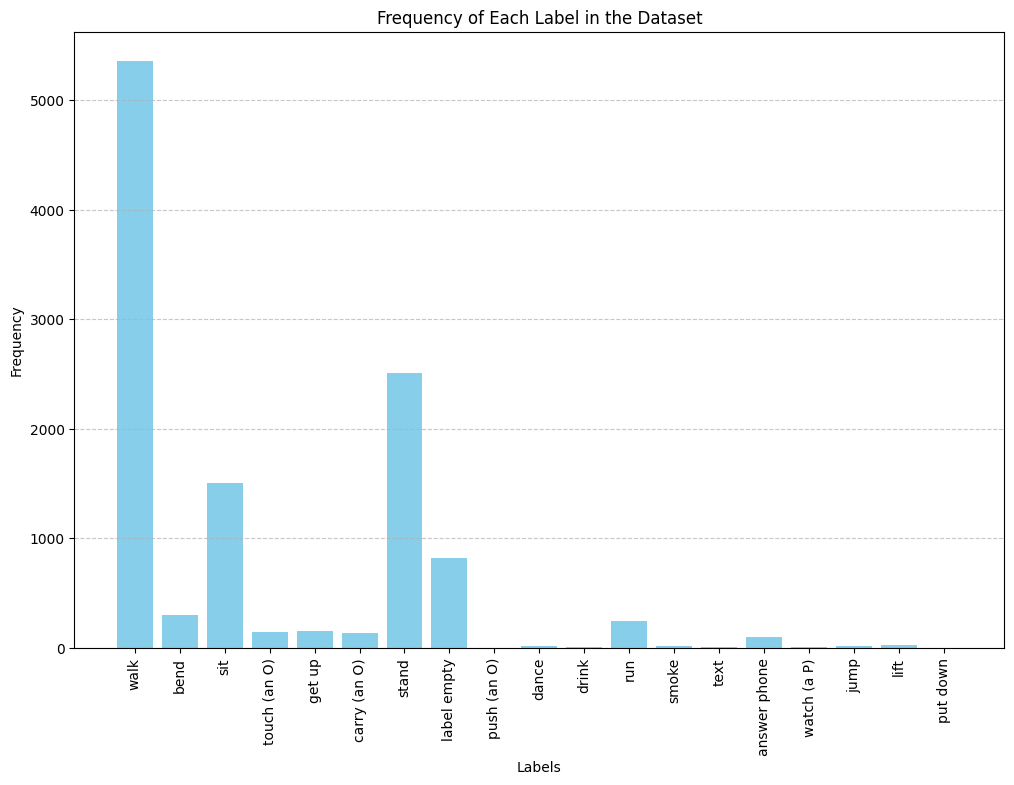

In [14]:
# 因为 labels_trimmed 是一个列表的列表，我们需要先将它们扁平化，然后计算频率
flat_labels = [label for sublist in labels_trimmed for label in sublist]

# 使用 Counter 计算每个标签的频率
label_counter = Counter(flat_labels)

# 获取数据用于绘图
labels, frequencies = zip(*label_counter.items())

# 可视化标签频率
plt.figure(figsize=(12, 8))
plt.bar(labels, frequencies, color='skyblue')
plt.title('Frequency of Each Label in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # 标签名称可能很长，旋转90度可以更好地展示
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [15]:
# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 因为labels_trimmed是一个列表的列表，我们需要先将它们扁平化，再进行编码
flat_labels = [label for sublist in labels_trimmed for label in sublist]

# 将分类标签转换为整数
integer_encoded = label_encoder.fit_transform(flat_labels)

# 如果需要后续查看或者转换回来，可以保存label_encoder
import pickle
pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))

# 转换为独热编码
onehot_encoded = to_categorical(integer_encoded)

# 因为我们需要将独热编码的标签重新分配回对应的文件组，我们需要使用原来的结构信息
split_indices = [len(sublist) for sublist in labels_trimmed]
onehot_labels = np.split(onehot_encoded, np.cumsum(split_indices)[:-1])



In [16]:
# 打印出每个文件组的独热编码标签数据的前几行，以确保转换正确
for i, labels in enumerate(onehot_labels):
    print(f"文件组 {i+1} 的独热编码标签样本:")
    print(labels[:5])  # 打印每个文件组的前五个独热编码标签


文件组 1 的独热编码标签样本:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
文件组 2 的独热编码标签样本:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
文件组 3 的独热编码标签样本:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
文件组 4 的独热编码标签样本:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 

In [17]:
# 检查特征和标签数量是否匹配
print(f"特征样本数: {len(rf_data_trimmed)}, 标签样本数: {len(onehot_labels)}")

特征样本数: 43, 标签样本数: 43


## Trianing

In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed


In [19]:
# 将列表的列表转换为 NumPy 数组
X = np.stack(rf_data_trimmed)  # 假设 rf_data_trimmed 是列表的列表
y = np.stack(onehot_labels)  # 假设 onehot_labels 是列表的列表
X_transposed = np.transpose(X, (0, 2, 1))  # 调整原始数据维度以适应 (样本数, 时间步, 特征数)

print("原始数据维度:", X.shape)
print("原始标签维度:", y.shape)
print("旋转标签维度:", X_transposed.shape)

def sliding_window(features, labels, window_size, step_size):
    segment_features = []
    segment_labels = []
    # 对每一个样本应用滑动窗口
    for sample_features, sample_labels in zip(features, labels):
        for start_pos in range(0, sample_features.shape[0] - window_size + 1, step_size):
            end_pos = start_pos + window_size
            segment_feat = sample_features[start_pos:end_pos, :]
            segment_label = sample_labels[start_pos:end_pos, :]
            segment_features.append(segment_feat)
            segment_labels.append(segment_label)
    return np.array(segment_features), np.array(segment_labels)

# 假设 X_transposed 和 y 已经是您处理后，时间步在第一维的数据
window_size = 50  # 定义窗口大小
step_size = 10    # 定义步长

X_windows, y_windows = sliding_window(X_transposed, y, window_size, step_size)

# 打印新的数据维度来确认变化
print("滑动窗口处理后的特征维度:", X_windows.shape)
print("滑动窗口处理后的标签维度:", y_windows.shape)



原始数据维度: (43, 301, 264)
原始标签维度: (43, 264, 19)
旋转标签维度: (43, 264, 301)
滑动窗口处理后的特征维度: (946, 50, 301)
滑动窗口处理后的标签维度: (946, 50, 19)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.07, random_state=42)

In [21]:
# 重新构建模型
model = Sequential([
    LSTM(50, input_shape=(100, 301), return_sequences=True),  # 输入形状：时间步长为264，每步有301个特征
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # 第二层LSTM，返回序列以供下一层处理
    Dropout(0.2),
    TimeDistributed(Dense(19, activation='softmax'))  # 在每个时间步输出19个类别的概率
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 显示模型结构
model.summary()


/Users/muuufan/anaconda3/envs/seq2seq/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        70,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 19)        │           969 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,569 (357.69 KB)

 Trainable params: 91,569 (357.69 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 训练模型，这里假设 X_train, y_train, X_test, y_test 已经正确准备和维度匹配
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3989 - loss: 2.4146 - val_accuracy: 0.4549 - val_loss: 1.8056
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4796 - loss: 1.7205 - val_accuracy: 0.4549 - val_loss: 1.6453
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5151 - loss: 1.5315 - val_accuracy: 0.5301 - val_loss: 1.5576
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5678 - loss: 1.4587 - val_accuracy: 0.5749 - val_loss: 1.4978
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5876 - loss: 1.4137 - val_accuracy: 0.5722 - val_loss: 1.4319
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5854 - loss: 1.3707 - val_accuracy: 0.5764 - val_loss: 1.3966
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6124 - loss: 1.3126 - val_accuracy: 0.5836 - val_loss: 1.3851
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5950 - loss: 1.3076 - val_accuracy: 0.5925 - v

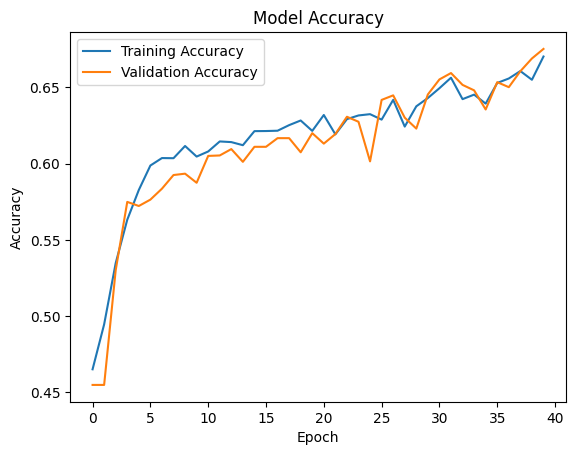

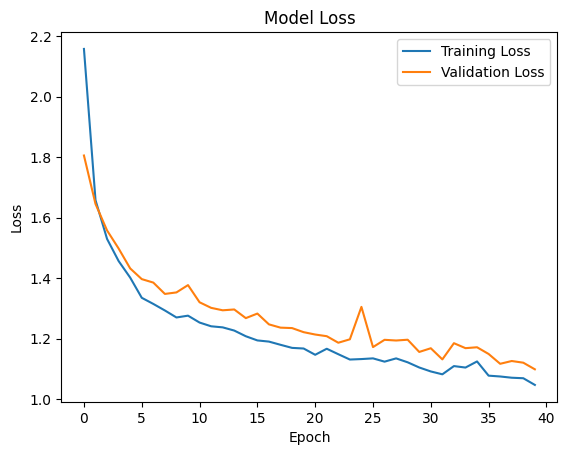

In [23]:
# 绘制训练和验证的准确率
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 绘制训练和验证的损失
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [24]:

# 读取CSV文件
new_data = pd.read_csv('RF1_csv/240228163700_30M__ch0Ref_Arr_HF.csv', header=None, skiprows=849, nrows=301)
new_data_normalized = scaler.fit_transform(new_data)
new_data_processed = []
new_data_processed.append(new_data_normalized)
print(np.array(new_data_processed[0]).shape)
print("RF数据（处理后）的前几行:")
print(new_data_processed[0][:5])
print("RF数据类型:")
print(type(new_data_processed[0]))

# 新建一个列表来保存平均后的数据
new_data_averaged = []

for data in new_data_processed:
    # 检查列数，确保是偶数列，如果是奇数列，去掉最后一列
    if data.shape[1] % 2 != 0:
        data = data[:, :-1]

    # 将数据重塑，使得每两列成为一组
    # data.shape[0] 是行数，data.shape[1]//2 是将列数减半
    reshaped_data = data.reshape(data.shape[0], -1, 2)
    
    # 计算每两列的平均值
    averaged_data = reshaped_data.mean(axis=2)
    
    # 将平均后的数据添加到新列表中
    new_data_averaged.append(averaged_data)
# 现在 rf_data_averaged 包含所有处理后的RF数据集

Validation = np.stack(new_data_averaged)
Validation_transposed = np.transpose(Validation, (0, 2, 1)) 
print("原始数据维度:", Validation.shape)
print("旋转标签维度:", Validation_transposed.shape)

# 使用模型进行预测
predictions = model.predict(Validation_transposed)

# 处理预测结果
predicted_class = np.argmax(predictions, axis=-1)
print("Predicted class:", predicted_class)

original_labels = label_encoder.inverse_transform(predicted_class.flatten())
print("Original labels:", original_labels)

(301, 591)
RF数据（处理后）的前几行:
[[0.03221829 0.29477643 0.29388446 ... 0.42441193 0.35283721 0.33417169]
 [0.1696515  0.29995063 0.21531595 ... 0.41047909 0.33995245 0.31824638]
 [0.31310601 0.44263274 0.40344119 ... 0.38026408 0.27813434 0.20598566]
 [0.32561922 0.46331949 0.39124756 ... 0.31104873 0.14175498 0.16793829]
 [0.3208314  0.44479031 0.30835818 ... 0.33069448 0.19490107 0.19845227]]
RF数据类型:
<class 'numpy.ndarray'>
原始数据维度: (1, 301, 295)
旋转标签维度: (1, 295, 301)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
Predicted class: [[14 14 14 14 14  7  7  7  7  7  7  7  7 14 14 14 14 14 14 14 14 14 17 17
  17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
  17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
  17 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
  14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 17 17 17 17 17 14 14 14
  14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
  14 14 14 14 14 14 14 14 14 14 